# Applied Machine Learning Finance

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn


from courselib.models.linear_models import LinearBinaryClassification, RidgeClassifier, LinearRegression
from courselib.models.nn import Sigmoid
from courselib.models.nn import MLP
from courselib.models.svm import BinaryKernelSVM
from courselib.models.svm import Kernel, RBFKernel, PolynomialKernel,LinearKernel
from courselib.utils.splits import train_test_split
from courselib.models.base import TrainableModel
from courselib.utils.metrics import binary_accuracy, mean_squared_error, mean_absolute_error,accuracy
from courselib.optimizers import GDOptimizer
from courselib.models.linear_models import LinearBinaryClassification, RidgeClassifier
from courselib.utils.normalization import min_max
from courselib.models.glm import LogisticRegression,sigmoid
from courselib.models.base import TrainableModel
from courselib.utils.preprocessing import labels_encoding
from courselib.models.svm import LinearSVM
from courselib.models.svm import BinaryKernelSVM
from courselib.utils.metrics import cross_entropy
from courselib.utils.normalization import standardize

## Functions

In [2]:
#pulling data from yfiance and converting it into a pandas dataframe
def fetch_data(ticker='SPY', start='2015-01-01', end='2023-12-31'):
    data = yf.download(ticker, start, end)
    df = pd.DataFrame(data)
    df.columns = df.columns.droplevel(1)
    return df



def compute_technical_indicators(data,amount,window):
    df = data.copy()

    df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()

    df[f'EMA_{window}'] = df['Close'].ewm(span=window, adjust=False).mean()

    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = delta.clip(upper=0).abs()
    avg_gain = up.ewm(window, adjust=False).mean()
    avg_loss = down.ewm(window, adjust=False).mean()
    rs = avg_gain / avg_loss
    df[f'RSI_{window}'] = 100 - (100 / (1 + rs))

    sma = df['Close'].rolling(window=20).mean()
    std = df['Close'].rolling(window=20).std()
    df['Bollinger_Upper'] = sma + 2 * std
    df['Bollinger_Lower'] = sma - 2 * std

    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['Daily_Return'] = df['Close'].pct_change()


    df['Rolling_5d_Std'] = df['Daily_Return'].rolling(window=5).std()

    for i in range(amount):
        df[f'Lag_{i+1}'] = df['Daily_Return'].shift(i+1)

    df['Momentum_10'] = df['Close'] - df['Close'].shift(10)
    return df

#transforming the stock data into train and test split with indicators and target as variables
def return_data(df, target_type='Target_01', train_frac=0.8,features='whole'):
    df['Trend'] = df['Close'].rolling(window=5).mean().shift(-1) > df['Close']
    df['Target_01'] = np.where(df['Trend'], 1, 0)
    df['Target_-1'] = np.where(df['Trend'], 1, -1)
    df = compute_technical_indicators(df, 3, 14)

    whole = ['SMA_14', 'EMA_14', 'RSI_14', 'Bollinger_Upper', 'Bollinger_Lower',
                'MACD', 'MACD_Signal', 'Daily_Return', 'Rolling_5d_Std',
                'Lag_1', 'Lag_2', 'Lag_3', 'Momentum_10', target_type, 'Close']
    
    correlation = ['Lag_2','Momentum_10','RSI_14','Lag_1',target_type,'Daily_Return']
    
    relevance = ['Daily_Return','Lag_1','RSI_14','Momentum_10',target_type,'Lag_2']
    
    lagged = ['Lag_1', 'Lag_2', 'Lag_3', target_type]
    
    if features == 'whole':
        features = whole
    elif features == 'correlation':
        features = correlation
    elif features == 'relevance':
        features = relevance
    elif features == 'lagged':
        features = lagged
    else:
        assert isinstance(features, list), "`features` must be 'whole' or a list of feature names."

    df = df[features]
    df = df.reset_index()
    df.dropna(inplace=True)

    X, Y, X_train, Y_train, X_test, Y_test = train_test_split(df.iloc[:, df.columns != 'Date'],
                                                              training_data_fraction=train_frac,
                                                              return_numpy=True,
                                                              shuffle=False,
                                                              class_column_name=target_type)
    return X, Y, X_train, Y_train, X_test, Y_test



In [3]:
#Logistic regression with lasso and ridge regularization option
class LogisticRegressionRegularization(TrainableModel):
    """
    Binary logistic regression model.

    Parameters:
        - w: Initial weights (array-like)
        - b: Initial bias (scalar)
        - optimizer: Optimizer object (e.g., GDOptimizer)
    """
    
    def __init__(self, w, b, optimizer,lam,type):
        super().__init__(optimizer)
        self.w = np.array(w, dtype=float)
        self.b = np.array(b, dtype=float)
        self.lam = lam
        self.type = type

    def loss_grad(self, X, y):
        residual = self.decision_function(X) - y
        if self.type == 'ridge':
            grad_w = X.T @ residual / len(X) + 2*self.lam*self.w
        elif self.type == 'lasso':
            grad_w = X.T @ residual / len(X) + self.lam*np.sign(self.w)
        else:
            grad_w = X.T @ residual / len(X)
        grad_b = np.mean(residual)
        return {"w": grad_w, "b": grad_b}
    
    def decision_function(self, X):
        return sigmoid(X @ self.w + self.b)
    
    def _get_params(self):
        """
        Return model parameters as a dict for the optimizer.
        """
        return {"w": self.w, "b": self.b}

    def __call__(self, X):
        return np.where(self.decision_function(X) >= 0.5, 1, 0)

## Model testing and Analysis


In [4]:
df = fetch_data('SPY', '2015-01-01', '2023-12-31')
df

/var/folders/pz/bkvmpwns7mgcx9s_bqb2lbyc0000gn/T/ipykernel_8837/1753287488.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,171.568024,172.779024,170.524067,172.361441,121465900
2015-01-05,168.469574,170.682757,168.160567,170.515727,169632600
2015-01-06,166.882736,169.304710,166.080972,168.778552,209151400
2015-01-07,168.962280,169.304701,167.768000,168.218984,125346700
2015-01-08,171.960556,172.177707,170.365400,170.382094,147217800
...,...,...,...,...,...
2023-12-22,464.874390,466.572348,462.960536,465.080490,67126600
2023-12-26,466.837341,467.750103,465.208094,465.286628,55387000
2023-12-27,467.681458,467.828672,466.091477,466.631275,68000300


In [5]:
#prepping all the data for the models, for the cases 1,0 as classification and 1,-1 and normalization with min max
X_01, Y_01, X_01_train, Y_01_train, X_01_test, Y_01_test = return_data(df, target_type='Target_01', train_frac=0.8, features='whole')
X_01 = min_max(X_01)
X_01_train = min_max(X_01_train)
X_01_test = min_max(X_01_test)
X_1, Y_1, X_1_train, Y_1_train, X_1_test, Y_1_test = return_data(df, target_type='Target_-1', train_frac=0.8, features='whole')
X_1 = min_max(X_1)
X_1_train = min_max(X_1_train)
X_1_test = min_max(X_1_test)
Y_ec, Y_ec_train, Y_ec_test = labels_encoding(Y_1), labels_encoding(Y_1_train), labels_encoding(Y_1_test)

### Logistic Regression

Lasso

In [6]:
#logistic regression like in the lecture with lasso added
w = [0] * X_01.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-1)

accuracy_regression = lambda y_true, y_pred: binary_accuracy(y_true, y_pred, class_labels=[0, 1])
metrics_dict_regression = {'accuracy': accuracy_regression, 'MSE': mean_squared_error}

model_regression = LogisticRegressionRegularization(w, b, optimizer,1e-3,'lasso')


metrics_history_regression = model_regression.fit(
    X_01_train, Y_01_train,
    num_epochs=20000,
    batch_size=len(X_01_train),
    compute_metrics=True,
    metrics_dict=metrics_dict_regression
)


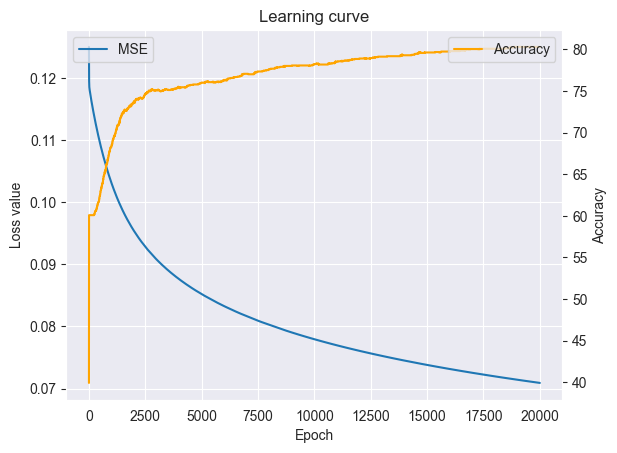

The final train accuracy: 80.29%
Test accuracy: 89.09%


In [469]:
# Plot learning curve of accuracy
fig, ax = plt.subplots()
ax.plot(range(len(metrics_history_regression['MSE'])), metrics_history_regression['MSE'], label='MSE')
ax.set_ylabel('Loss value')
ax2 = ax.twinx()
ax2.plot(range(len(metrics_history_regression['accuracy'])), metrics_history_regression['accuracy'], color='orange', label='Accuracy')
ax2.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
plt.title('Learning curve')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid()
plt.show()

# Evaluation
print(f'The final train accuracy: {metrics_history_regression["accuracy"][-1]:.2f}%')
print(f'Test accuracy: {accuracy_regression(model_regression.decision_function(X_01_test), Y_01_test):.2f}%')

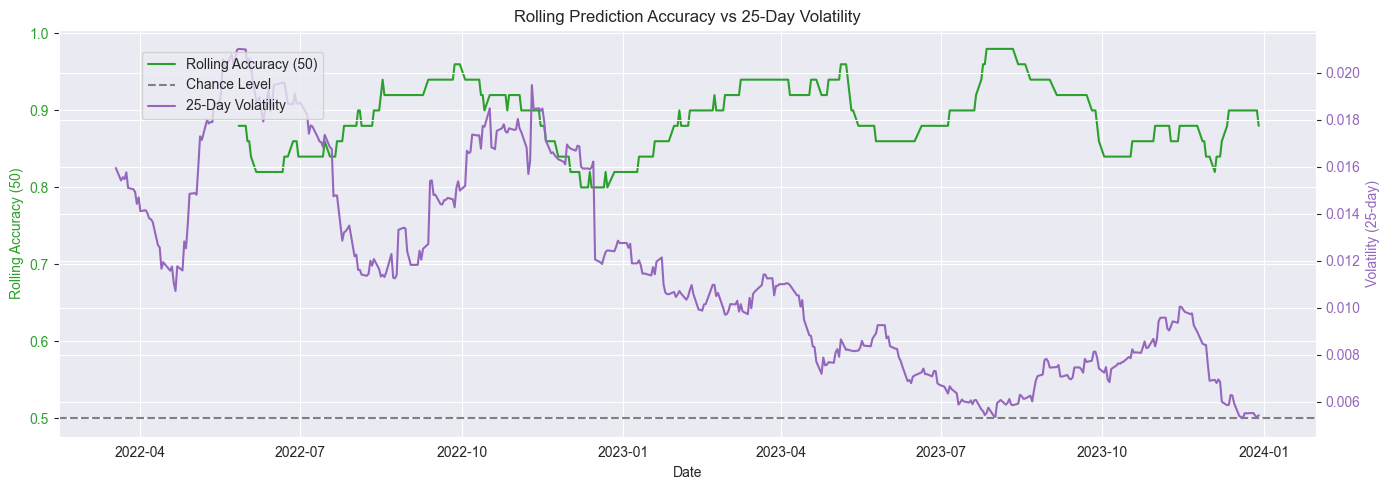

In [10]:
#plot of accuracy vs volatility over the test time
if 'Date' not in df.columns and df.index.name == 'Date':
    df = df.reset_index()

df_copy = df.copy()
df_copy['Trend'] = df_copy['Close'].rolling(window=5).mean().shift(-1) > df_copy['Close']
df_copy['Target_01'] = np.where(df_copy['Trend'], 1, 0)
df_copy['Target_-1'] = np.where(df_copy['Trend'], 1, -1)
df_copy = compute_technical_indicators(df_copy, 3, 14)
df_copy = df_copy.reset_index(drop=True)
df_copy.dropna(inplace=True)

date_series = df_copy['Date'].iloc[-len(X_01):].values
split_idx = int(len(X_01) * 0.8)
test_dates = date_series[split_idx:]

Y_pred_reg = model_regression(X_01_test)
Y_pred_labels_reg = (Y_pred_reg > 0.5).astype(int).flatten()
Y_true_labels_reg = Y_01_test.flatten()

results_df_reg = pd.DataFrame({
    'Date': test_dates,
    'True': Y_true_labels_reg,
    'Predicted': Y_pred_labels_reg
})
#rolling accuracy and volatility as pointwise doesnt give a graph to work with
results_df_reg['Correct'] = results_df_reg['True'] == results_df_reg['Predicted']
results_df_reg['Rolling_Accuracy'] = results_df_reg['Correct'].rolling(window=50).mean()

df_copy['Daily_Return'] = df_copy['Close'].pct_change()
df_copy['Volatility_15d'] = df_copy['Daily_Return'].rolling(window=25).std()
vol_series = df_copy['Volatility_15d'].iloc[-len(X_01):].values
vol_test = vol_series[split_idx:]

fig, ax1 = plt.subplots(figsize=(14, 5))

color1 = 'tab:green'
ax1.set_xlabel('Date')
ax1.set_ylabel('Rolling Accuracy (50)', color=color1)
ax1.plot(test_dates, results_df_reg['Rolling_Accuracy'], color=color1, label='Rolling Accuracy (50)')
ax1.axhline(0.5, color='gray', linestyle='--', label='Chance Level')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:purple'
ax2.set_ylabel('Volatility (25-day)', color=color2)
ax2.plot(test_dates, vol_test, color=color2, label='25-Day Volatility')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Rolling Prediction Accuracy vs 25-Day Volatility')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

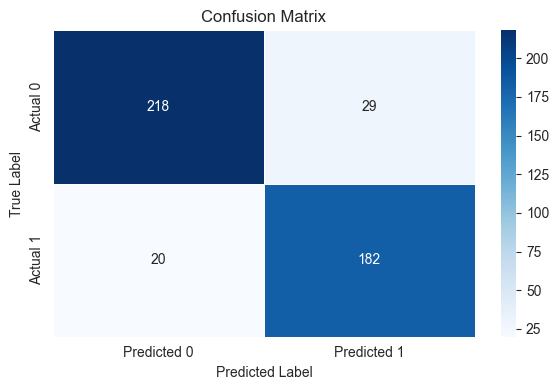

In [471]:
#confusion matrix of the target variable
y_pred_cont = model_regression(X_01_test)

y_pred = (y_pred_cont >= 0.5).astype(int)

y_true = np.array(Y_01_test)

cm_array = np.zeros((2, 2), dtype=int)

for t, p in zip(y_true, y_pred):
    cm_array[t][p] += 1

df_cm = pd.DataFrame(cm_array, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

Ridge

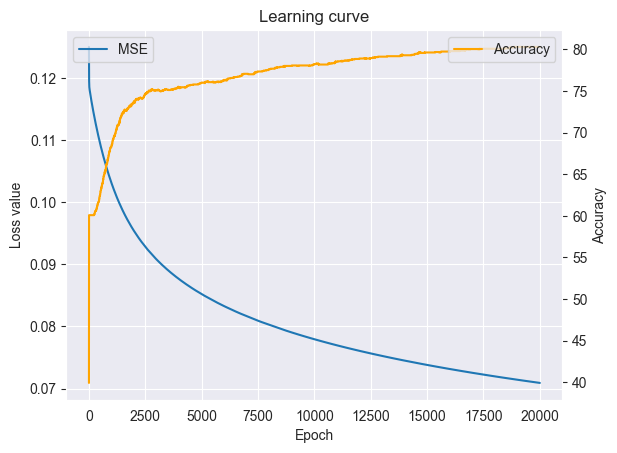

The final train accuracy: 80.62%
Test accuracy: 88.42%


In [472]:
#ridge regression as comparison
w = [0] * X_01.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-1)

model_regression_ridge = LogisticRegressionRegularization(w, b, optimizer, 1e-4, 'ridge')

metrics_history_ridge = model_regression_ridge.fit(
    X_01_train, Y_01_train,
    num_epochs=20000,
    batch_size=len(X_01_train),
    compute_metrics=True,
    metrics_dict=metrics_dict_regression
)

fig, ax = plt.subplots()
ax.plot(range(len(metrics_history_regression['MSE'])), metrics_history_regression['MSE'], label='MSE')
ax.set_ylabel('Loss value')
ax2 = ax.twinx()
ax2.plot(range(len(metrics_history_regression['accuracy'])), metrics_history_regression['accuracy'], color='orange', label='Accuracy')
ax2.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
plt.title('Learning curve')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid()
plt.show()

print(f'The final train accuracy: {metrics_history_ridge["accuracy"][-1]:.2f}%')
print(f'Test accuracy: {accuracy_regression(model_regression_ridge.decision_function(X_01_test), Y_01_test):.2f}%')

### Kernel SVM

In [473]:
#svm with polynomial and rbf kernels, to test which values and kernel works best
kernels = ['linear', 'polynomial', 'rbf']
for i in range(10):
    
    svm_poly = BinaryKernelSVM(kernel='polynomial', degree=i)
    svm_poly.fit(X_1_train, Y_1_train)
    

    test_acc = binary_accuracy(svm_poly(X_1_test), Y_1_test)

    train_acc = binary_accuracy(svm_poly(X_1_train), Y_1_train)

    print(f'Test accuracy degree {i}: Test accuracy: {test_acc:.4f}, Train accuracy: {train_acc:.4f}')


sigma_values = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
for i in sigma_values:
    
    svm_rbf_values = BinaryKernelSVM(kernel='rbf', sigma=i)
    svm_rbf_values.fit(X_1_train, Y_1_train)
   

    test_acc = binary_accuracy(svm_rbf_values(X_1_test), Y_1_test)

    train_acc = binary_accuracy(svm_rbf_values(X_1_train), Y_1_train)

    print(f'Test accuracy sigma {i}: Test accuracy: {test_acc:.4f}, Train accuracy: {train_acc:.4f}')

 


Test accuracy degree 0: Test accuracy: 55.0111, Train accuracy: 60.0780
Test accuracy degree 1: Test accuracy: 78.3964, Train accuracy: 82.4610
Test accuracy degree 2: Test accuracy: 59.9109, Train accuracy: 89.1982
Test accuracy degree 3: Test accuracy: 56.3474, Train accuracy: 91.4811
Test accuracy degree 4: Test accuracy: 55.2339, Train accuracy: 92.4833
Test accuracy degree 5: Test accuracy: 57.9065, Train accuracy: 93.7082
Test accuracy degree 6: Test accuracy: 68.1514, Train accuracy: 94.7105
Test accuracy degree 7: Test accuracy: 65.0334, Train accuracy: 95.6570
Test accuracy degree 8: Test accuracy: 59.6882, Train accuracy: 94.1537
Test accuracy degree 9: Test accuracy: 56.3474, Train accuracy: 90.2561
Test accuracy sigma 0.01: Test accuracy: 55.0111, Train accuracy: 100.0000
Test accuracy sigma 0.05: Test accuracy: 55.0111, Train accuracy: 96.9376
Test accuracy sigma 0.1: Test accuracy: 54.7884, Train accuracy: 93.2628
Test accuracy sigma 0.2: Test accuracy: 70.8241, Train acc

RBF Kernel


Test accuracy sigma 1: 87.3051, Train accuracy: 81.4031


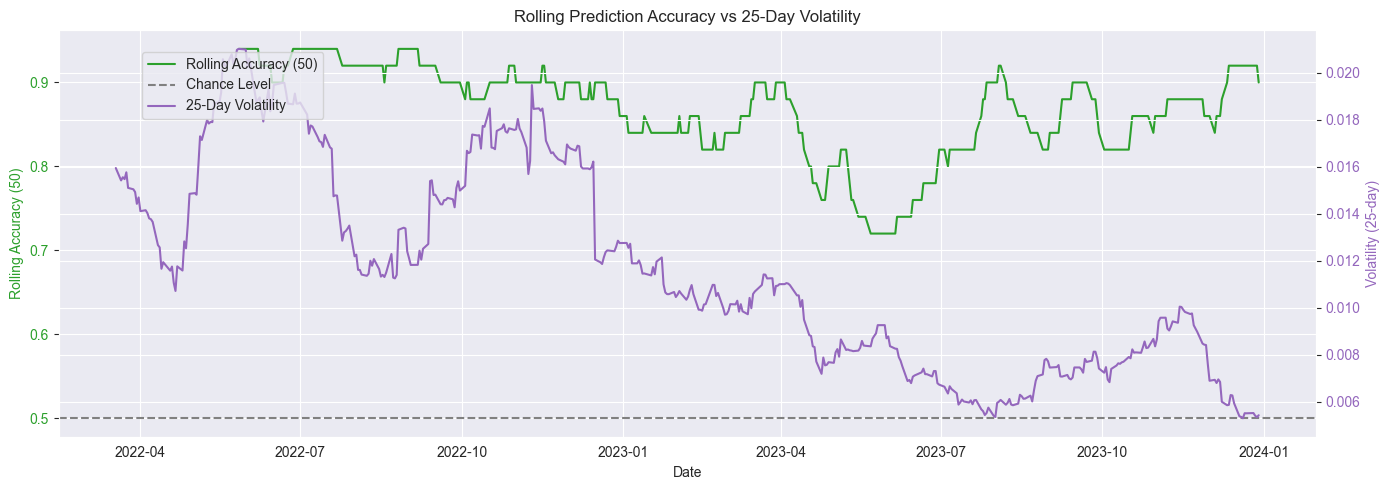

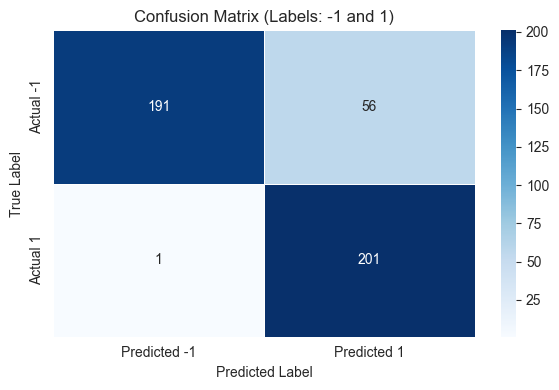

In [11]:
#rbf with the best sigma for analysis
svm_rbf = BinaryKernelSVM(kernel='rbf', sigma=1)
svm_rbf.fit(X_1_train, Y_1_train)

test_acc = binary_accuracy(svm_rbf(X_1_test), Y_1_test)
train_acc = binary_accuracy(svm_rbf(X_1_train), Y_1_train)

print(f'Test accuracy sigma {1}: {test_acc:.4f}, Train accuracy: {train_acc:.4f}')

df_copy = df.copy()
df_copy['Trend'] = df_copy['Close'].rolling(window=5).mean().shift(-1) > df_copy['Close']
df_copy['Target_01'] = np.where(df_copy['Trend'], 1, 0)
df_copy['Target_-1'] = np.where(df_copy['Trend'], 1, -1)
df_copy = compute_technical_indicators(df_copy, 3, 14)
df_copy = df_copy.reset_index()  # Ensure 'Date' is a column
df_copy.dropna(inplace=True)

date_series = df_copy['Date'].iloc[-len(X_1):].values
split_idx = int(len(X_1) * 0.8)
test_dates = date_series[split_idx:]

Y_pred_svm = svm_rbf(X_1_test)
results_df_svm = pd.DataFrame({
    'Date': test_dates,
    'True': Y_1_test,
    'Predicted': Y_pred_svm
})
#rolling accuracy and volatility as pointwise doesnt give a graph to work with
results_df_svm['Correct'] = results_df_svm['True'] == results_df_svm['Predicted']
results_df_svm['Rolling_Accuracy'] = results_df_svm['Correct'].rolling(window=50).mean()

df_copy['Daily_Return'] = df_copy['Close'].pct_change()
df_copy['Volatility_15d'] = df_copy['Daily_Return'].rolling(window=25).std()
vol_series = df_copy['Volatility_15d'].iloc[-len(X_1):].values
vol_test = vol_series[split_idx:]

fig, ax1 = plt.subplots(figsize=(14, 5))

color1 = 'tab:green'
ax1.set_xlabel('Date')
ax1.set_ylabel('Rolling Accuracy (50)', color=color1)
ax1.plot(test_dates, results_df_svm['Rolling_Accuracy'], color=color1, label='Rolling Accuracy (50)')
ax1.axhline(0.5, color='gray', linestyle='--', label='Chance Level')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:purple'
ax2.set_ylabel('Volatility (25-day)', color=color2)
ax2.plot(test_dates, vol_test, color=color2, label='25-Day Volatility')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Rolling Prediction Accuracy vs 25-Day Volatility')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Y_pred_cm = np.where(Y_pred_svm >= 0.5, 1, -1)

Y_true = np.array(Y_1_test)

labels = [-1, 1]
cm_array = np.zeros((2, 2), dtype=int)

for true, pred in zip(Y_true, Y_pred_cm):
    true_idx = labels.index(true)
    pred_idx = labels.index(pred)
    cm_array[true_idx][pred_idx] += 1

df_cm = pd.DataFrame(cm_array, index=["Actual -1", "Actual 1"], columns=["Predicted -1", "Predicted 1"])

plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.title("Confusion Matrix (Labels: -1 and 1)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

### Neural Network

In [13]:
#neural network for comparison, but apart from accuracy way worse in runtime
#run time about 5 min
metrics_dict_nn = {
    "accuracy": accuracy,
    "loss": mean_squared_error
}


optimizer = GDOptimizer(learning_rate=1)

model_nn = MLP(widths=[14, 64,32, 2], optimizer=optimizer, activation='ReLU', output_activation='Linear', loss='MSE')

metrics_history_nn = model_nn.fit(X_1_train, Y_ec_train, num_epochs=15000, batch_size=len(X_1_train), compute_metrics=True,
                            metrics_dict=metrics_dict_nn)




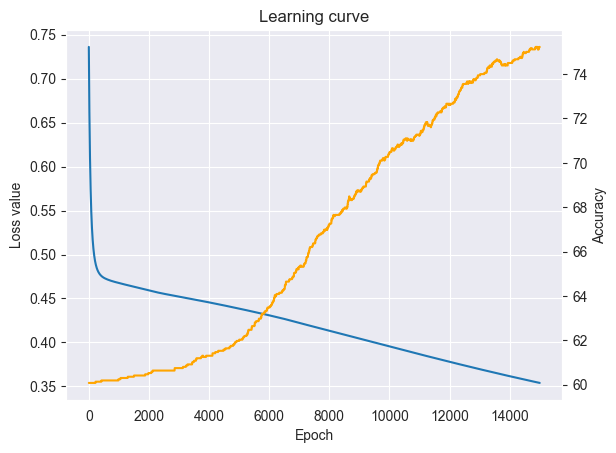

The final train accuracy: 75.2%
Test accuracy: 81.3%


In [75]:
#accuray plot learning curve
fig, ax = plt.subplots()

ax.plot(range(len(metrics_history_nn['loss'])), metrics_history_nn['loss'])
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(metrics_history_nn['accuracy'])), metrics_history_nn['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Learning curve')
plt.grid()
plt.show()

print(f'The final train accuracy: {round(metrics_history_nn["accuracy"][-1], 1)}%')
print(f'Test accuracy: {round(accuracy(model_nn.decision_function(X_1_test), Y_ec_test), 1)}%')



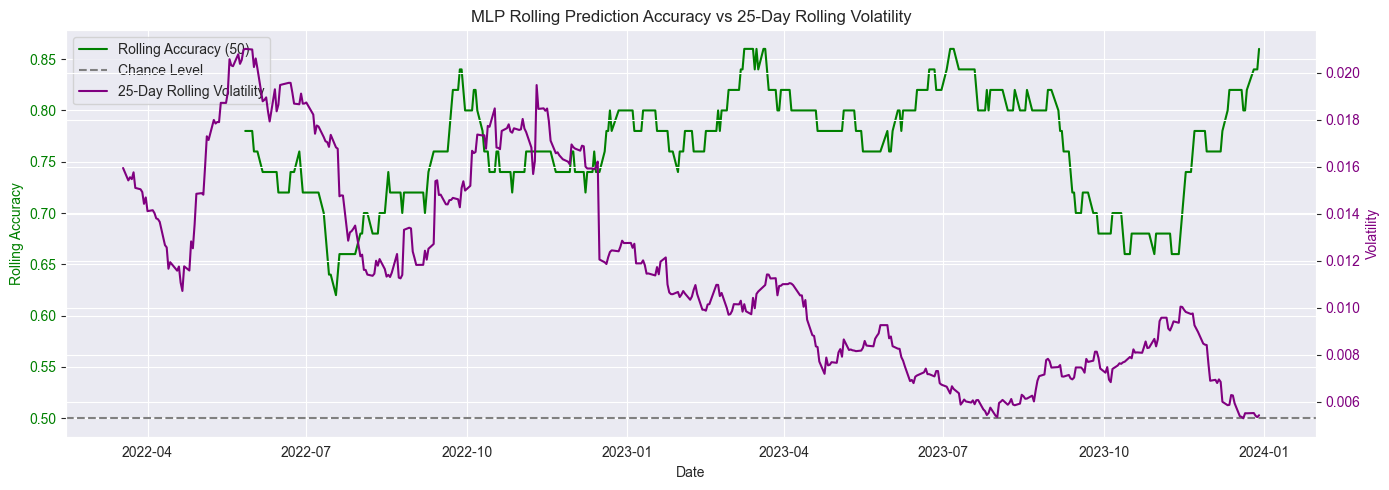

In [14]:
#accuracy vs volatility over test time
Y_pred = model_nn(X_1_test)

if Y_pred.ndim == 1 or Y_pred.shape[1] == 1:
    Y_pred_labels = (Y_pred > 0).astype(int).flatten()
    Y_true_labels = Y_ec_test.flatten() if Y_ec_test.ndim == 1 else Y_ec_test.argmax(axis=1)
else:
    Y_pred_labels = np.argmax(Y_pred, axis=1)
    Y_true_labels = np.argmax(Y_ec_test, axis=1)

df_copy = df.copy()
df_copy['Trend'] = df_copy['Close'].rolling(window=5).mean().shift(-1) > df_copy['Close']
df_copy['Target_01'] = np.where(df_copy['Trend'], 1, 0)
df_copy['Target_-1'] = np.where(df_copy['Trend'], 1, -1)


df_copy = compute_technical_indicators(df_copy, 3, 14)

df_copy = df_copy.reset_index()
df_copy.dropna(inplace=True)

test_dates = df_copy['Date'].iloc[-len(X_1_test):].values
results_df = pd.DataFrame({
    'Date': test_dates,
    'True': Y_true_labels,
    'Predicted': Y_pred_labels
})
#rolling accuracy and volatility as pointwise doesnt give a graph to work with
results_df['Correct'] = results_df['True'] == results_df['Predicted']
results_df['Rolling_Accuracy'] = results_df['Correct'].rolling(window=50).mean()

df_copy['Daily_Return'] = df_copy['Close'].pct_change()
df_copy['Volatility_15d'] = df_copy['Daily_Return'].rolling(window=25).std()

vol_series = df_copy['Volatility_15d'].iloc[-len(X_1):].values
date_series = df_copy['Date'].iloc[-len(X_1):].values
split_idx = int(len(X_1) * 0.8)
vol_test = vol_series[split_idx:]
vol_dates = date_series[split_idx:]

fig, ax1 = plt.subplots(figsize=(14, 5))

ax1.plot(results_df['Date'], results_df['Rolling_Accuracy'], color='green', label='Rolling Accuracy (50)')
ax1.axhline(0.5, color='gray', linestyle='--', label='Chance Level')
ax1.set_ylabel('Rolling Accuracy', color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
ax2.plot(vol_dates, vol_test, color='purple', label='25-Day Rolling Volatility')
ax2.set_ylabel('Volatility', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

plt.title('MLP Rolling Prediction Accuracy vs 25-Day Rolling Volatility')
ax1.set_xlabel('Date')
plt.xticks(rotation=45)
ax1.grid(True)
fig.tight_layout()

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()


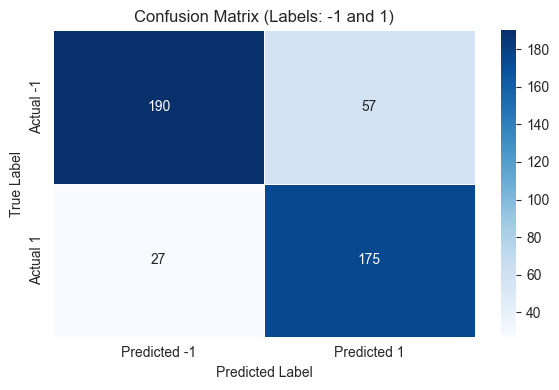

In [77]:
#confusio matrix target variable
Y_pred_cont = model_nn(X_1_test)

Y_pred_cm = np.where(Y_pred_cont >= 0.5, 1, -1)

Y_true = np.array(Y_1_test)

labels = [-1, 1]
cm_array = np.zeros((2, 2), dtype=int)

for true, pred in zip(Y_true, Y_pred_cm):
    true_idx = labels.index(true)
    pred_idx = labels.index(pred)
    cm_array[true_idx][pred_idx] += 1

df_cm = pd.DataFrame(cm_array, index=["Actual -1", "Actual 1"], columns=["Predicted -1", "Predicted 1"])

plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.title("Confusion Matrix (Labels: -1 and 1)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

### Baseline Model using autoregressive model and lagged returns

In [15]:
#autoregressive regression using only lagged values for comparison
X_lag, Y_lag, X_lag_train, Y_lag_train, X_lag_test, Y_lag_test = return_data(df,target_type='Target_01',train_frac=.8,features = 'lagged')
X_lag = min_max(X_lag)
X_lag_train = min_max(X_lag_train)
X_lag_test = min_max(X_lag_test)
w = [0] * X_lag.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=2e-2)

accuracy_lag = lambda y_true, y_pred: binary_accuracy(y_true, y_pred, class_labels=[0, 1])
metrics_dict_lag = {'accuracy': accuracy_lag, 'MSE': mean_squared_error}

model_lag = LinearRegression(w, b, optimizer)

metrics_history_lag = model_lag.fit(
    X_lag_train, Y_lag_train,
    num_epochs=20000,
    batch_size=len(X_lag_train),
    compute_metrics=True,
    metrics_dict=metrics_dict_lag
)


Final train accuracy (baseline): 63.55%
Test accuracy (baseline): 64.38%


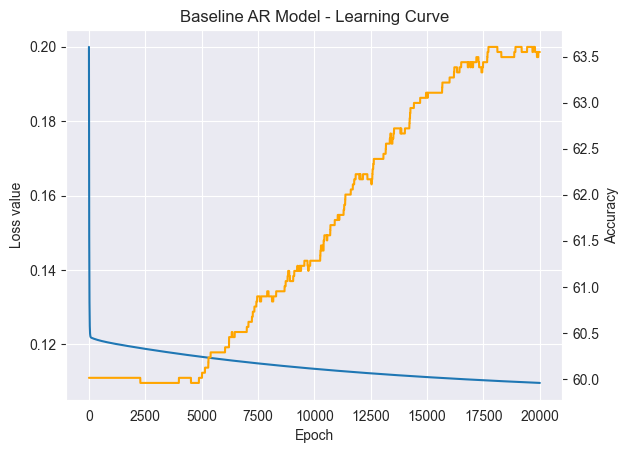

In [79]:
#learning curve accuracy
fig, ax = plt.subplots()
ax.plot(metrics_history_lag['MSE'], label='MSE')
ax.set_ylabel('Loss value')
ax.set_xlabel('Epoch')
ax2 = ax.twinx()
ax2.plot(metrics_history_lag['accuracy'], color='orange', label='Accuracy')
ax2.set_ylabel('Accuracy')
plt.title('Baseline AR Model - Learning Curve')
plt.grid()

train_acc = metrics_history_lag["accuracy"][-1]
test_acc = accuracy_lag(model_lag.decision_function(X_lag_test), Y_lag_test)

print(f'Final train accuracy (baseline): {train_acc :.2f}%')
print(f'Test accuracy (baseline): {test_acc :.2f}%')

plt.show()

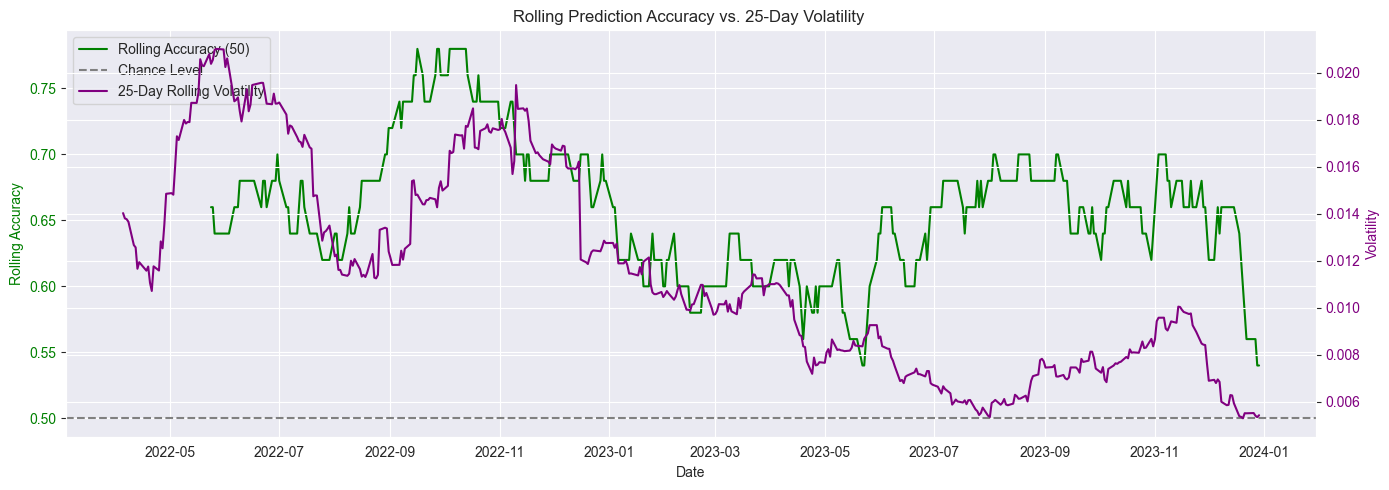

In [16]:
#accuracy vs volatility
Y_true = Y_lag_test.flatten() if Y_lag_test.ndim > 1 else Y_lag_test
Y_pred_raw = model_lag(X_lag_test)
Y_pred = (Y_pred_raw > 0.5).astype(int).flatten()

df_copy = df.copy()
df_copy['Trend'] = df_copy['Close'].rolling(window=5).mean().shift(-1) > df_copy['Close']
df_copy['Target_01'] = np.where(df_copy['Trend'], 1, 0)
df_copy['Target_-1'] = np.where(df_copy['Trend'], 1, -1)


df_copy = compute_technical_indicators(df_copy, 3, 14)

df_copy = df_copy.reset_index()
df_copy.dropna(inplace=True)

test_dates = df_copy['Date'].iloc[-len(X_lag_test):].values
results_df = pd.DataFrame({
    'Date': test_dates,
    'True': Y_true,
    'Predicted': Y_pred
})
#rolling accuracy and volatility as pointwise doesnt give a graph to work with
results_df['Correct'] = results_df['True'] == results_df['Predicted']
results_df['Rolling_Accuracy'] = results_df['Correct'].rolling(window=50).mean()

df_copy['Daily_Return'] = df_copy['Close'].pct_change()
df_copy['Volatility_15d'] = df_copy['Daily_Return'].rolling(window=25).std()

vol_series = df_copy['Volatility_15d'].iloc[-len(X_lag):].values
date_series = df_copy['Date'].iloc[-len(X_lag):].values
split_idx = int(len(X_lag) * 0.8)
vol_test = vol_series[split_idx:]
vol_dates = date_series[split_idx:]

fig, ax1 = plt.subplots(figsize=(14, 5))

ax1.plot(results_df['Date'], results_df['Rolling_Accuracy'], color='green', label='Rolling Accuracy (50)')
ax1.axhline(0.5, color='gray', linestyle='--', label='Chance Level')
ax1.set_ylabel('Rolling Accuracy', color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
ax2.plot(vol_dates, vol_test, color='purple', label='25-Day Rolling Volatility')
ax2.set_ylabel('Volatility', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

plt.title('Rolling Prediction Accuracy vs. 25-Day Volatility ')
ax1.set_xlabel('Date')
plt.xticks(rotation=45)
ax1.grid(True)
fig.tight_layout()

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.show()


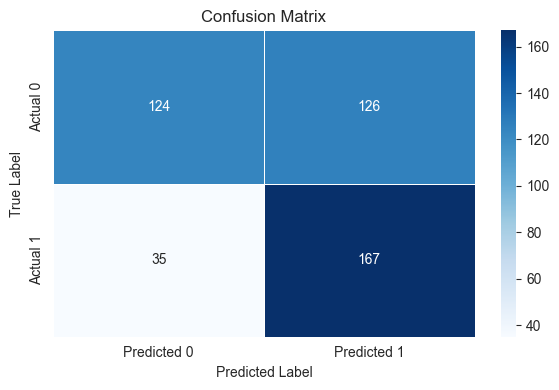

In [82]:
#confusion matrix
y_pred_cont = model_lag(X_lag_test)

y_pred = (y_pred_cont >= 0.5).astype(int)

y_true = np.array(Y_lag_test)

cm_array = np.zeros((2, 2), dtype=int)

for t, p in zip(y_true, y_pred):
    cm_array[t][p] += 1

df_cm = pd.DataFrame(cm_array, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

## Transferability 

Neural Network


In [83]:
#same data preparation for a different stock
df_transferability = fetch_data('AMZN', '2015-01-01', '2023-12-31')
X_1_transfer, Y_1_transfer, X_1_train_transfer, Y_1_train_transfer, X_1_test_transfer, Y_1_test_transfer = return_data(df_transferability,target_type='Target_-1',train_frac=.8)
X_1_transfer = min_max(X_1_transfer)
X_1_train_transfer = min_max(X_1_train_transfer)
X_1_test_transfer = min_max(X_1_test_transfer)
Y_1_transfer, Y_1_train_transfer, Y_1_test_transfer = labels_encoding(Y_1_transfer), labels_encoding(Y_1_train_transfer), labels_encoding(Y_1_test_transfer)

/var/folders/pz/bkvmpwns7mgcx9s_bqb2lbyc0000gn/T/ipykernel_3367/1753287488.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [84]:
print(f'The final train accuracy: {round(metrics_history_nn["accuracy"][-1], 1)}%')
print(f'Test accuracy: {round(accuracy(model_nn.decision_function(X_1_test_transfer), Y_1_test_transfer), 1)}%')

The final train accuracy: 75.2%
Test accuracy: 75.3%


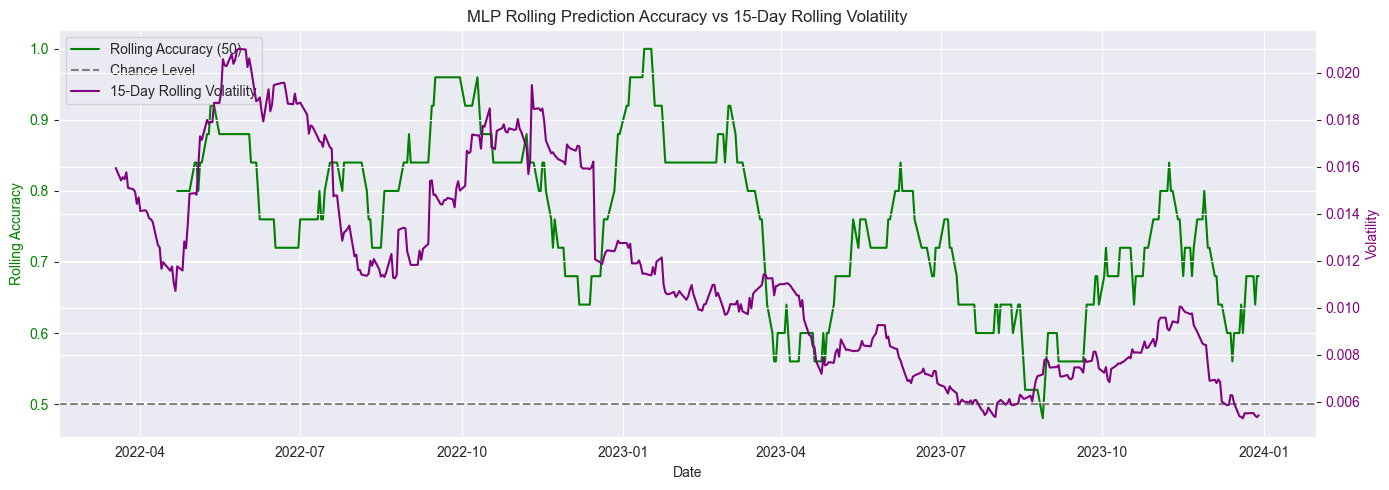

In [85]:
#accuracy vs volatility
Y_pred_transfer = model_nn(X_1_test_transfer)


if Y_pred_transfer.ndim == 1 or Y_pred_transfer.shape[1] == 1:
    Y_pred_transfer_labels = (Y_pred_transfer > 0).astype(int).flatten()
    Y_true_transfer_labels = Y_1_test_transfer.flatten() if Y_1_test_transfer.ndim == 1 else Y_1_test_transfer.argmax(axis=1)
else:
    Y_pred_transfer_labels = np.argmax(Y_pred_transfer, axis=1)
    Y_true_transfer_labels = np.argmax(Y_1_test_transfer, axis=1)

df_copy = df.copy()
df_copy['Trend'] = df_copy['Close'].rolling(window=5).mean().shift(-1) > df_copy['Close']
df_copy['Target_01'] = np.where(df_copy['Trend'], 1, 0)
df_copy['Target_-1'] = np.where(df_copy['Trend'], 1, -1)


df_copy = compute_technical_indicators(df_copy, 3, 14)

df_copy = df_copy.reset_index()
df_copy.dropna(inplace=True)

test_dates = df_copy['Date'].iloc[-len(X_1_test_transfer):].values
results_df = pd.DataFrame({
    'Date': test_dates,
    'True': Y_true_transfer_labels,
    'Predicted': Y_pred_transfer_labels
})
#rolling accuracy and volatility as pointwise doesnt give a graph to work with
results_df['Correct'] = results_df['True'] == results_df['Predicted']
results_df['Rolling_Accuracy'] = results_df['Correct'].rolling(window=25).mean()

df_copy['Daily_Return'] = df_copy['Close'].pct_change()
df_copy['Volatility_15d'] = df_copy['Daily_Return'].rolling(window=25).std()

vol_series = df_copy['Volatility_15d'].iloc[-len(X_1_transfer):].values
date_series = df_copy['Date'].iloc[-len(X_1_transfer):].values
split_idx = int(len(X_1_transfer) * 0.8)
vol_test = vol_series[split_idx:]
vol_dates = date_series[split_idx:]

fig, ax1 = plt.subplots(figsize=(14, 5))

ax1.plot(results_df['Date'], results_df['Rolling_Accuracy'], color='green', label='Rolling Accuracy (50)')
ax1.axhline(0.5, color='gray', linestyle='--', label='Chance Level')
ax1.set_ylabel('Rolling Accuracy', color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
ax2.plot(vol_dates, vol_test, color='purple', label='15-Day Rolling Volatility')
ax2.set_ylabel('Volatility', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

plt.title('MLP Rolling Prediction Accuracy vs 15-Day Rolling Volatility')
ax1.set_xlabel('Date')
plt.xticks(rotation=45)
ax1.grid(True)
fig.tight_layout()

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()

Logistic Regression

In [86]:
#data preparation different stock
df_transferability = fetch_data('AMZN', '2015-01-01', '2023-12-31')
X_01_transfer, Y_01_transfer, X_01_train_transfer, Y_01_train_transfer, X_01_test_transfer, Y_01_test_transfer = return_data(df_transferability,target_type='Target_01',train_frac=.8)
X_01_transfer = min_max(X_01_transfer)
X_01_train_transfer = min_max(X_01_train_transfer)
X_01_test_transfer = min_max(X_01_test_transfer)


/var/folders/pz/bkvmpwns7mgcx9s_bqb2lbyc0000gn/T/ipykernel_3367/1753287488.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [87]:
print(f'The final train accuracy: {metrics_history_regression["accuracy"][-1]:.2f}%')
print(f'Test accuracy: {accuracy_regression(model_regression.decision_function(X_01_test_transfer), Y_01_test_transfer):.2f}%')

The final train accuracy: 80.29%
Test accuracy: 77.06%


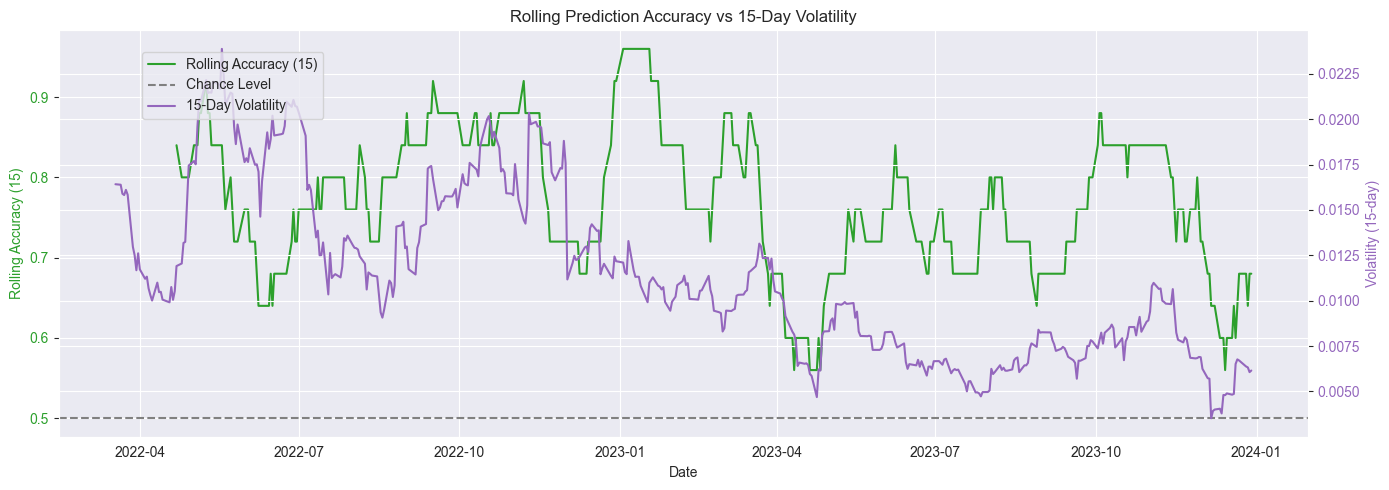

In [88]:
#accuracy vs volatility
if 'Date' not in df.columns and df.index.name == 'Date':
    df = df.reset_index()

df_copy = df.copy()
df_copy['Trend'] = df_copy['Close'].rolling(window=5).mean().shift(-1) > df_copy['Close']
df_copy['Target_01'] = np.where(df_copy['Trend'], 1, 0)
df_copy['Target_-1'] = np.where(df_copy['Trend'], 1, -1)
df_copy = compute_technical_indicators(df_copy, 3, 14)
df_copy = df_copy.reset_index(drop=True)
df_copy.dropna(inplace=True)

date_series = df_copy['Date'].iloc[-len(X_01_transfer):].values
split_idx = int(len(X_01_transfer) * 0.8)
test_dates = date_series[split_idx:]

Y_pred_transfer = model_regression(X_01_test_transfer)
Y_pred_labels = (Y_pred_transfer > 0.5).astype(int).flatten()
Y_true_labels = Y_01_test_transfer.flatten()

results_df = pd.DataFrame({
    'Date': test_dates,
    'True': Y_true_labels,
    'Predicted': Y_pred_labels
})
#rolling accuracy and volatility as pointwise doesnt give a graph to work with
results_df['Correct'] = results_df['True'] == results_df['Predicted']
results_df['Rolling_Accuracy'] = results_df['Correct'].rolling(window=25).mean()

df_copy['Daily_Return'] = df_copy['Close'].pct_change()
df_copy['Volatility_15d'] = df_copy['Daily_Return'].rolling(window=15).std()
vol_series = df_copy['Volatility_15d'].iloc[-len(X_01_transfer):].values
vol_test = vol_series[split_idx:]

fig, ax1 = plt.subplots(figsize=(14, 5))

color1 = 'tab:green'
ax1.set_xlabel('Date')
ax1.set_ylabel('Rolling Accuracy (15)', color=color1)
ax1.plot(test_dates, results_df['Rolling_Accuracy'], color=color1, label='Rolling Accuracy (15)')
ax1.axhline(0.5, color='gray', linestyle='--', label='Chance Level')
ax1.tick_params(axis='y', labelcolor=color1)
ax2 = ax1.twinx()
color2 = 'tab:purple'
ax2.set_ylabel('Volatility (15-day)', color=color2)
ax2.plot(test_dates, vol_test, color=color2, label='15-Day Volatility')
ax2.tick_params(axis='y', labelcolor=color2)


plt.title('Rolling Prediction Accuracy vs 15-Day Volatility')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Daily Return Analysis and Trading Strategies

## Functions


In [475]:
def return_data_daily_return(df, target_type='Target_01', train_frac=0.8,features='whole'):
    df['Target_Sign'] = np.sign(df['Close'].shift(-1) - df['Close']).shift(-1)
    df['Target_Sign_01'] = df['Target_Sign'].where(df['Target_Sign'].isna(),np.where(df['Target_Sign'] > 0, 1, 0))    
    df = compute_technical_indicators(df, 3, 14)

    whole = ['SMA_14', 'EMA_14', 'RSI_14', 'Bollinger_Upper', 'Bollinger_Lower',
                'MACD', 'MACD_Signal', 'Daily_Return', 'Rolling_5d_Std',
                'Lag_1', 'Lag_2', 'Lag_3', 'Momentum_10', target_type, 'Close']
    
    correlation = ['Lag_2','Momentum_10','RSI_14','Lag_1',target_type,'Daily_Return']
    
    relevance = ['Daily_Return','Lag_1','RSI_14','Momentum_10',target_type,'Lag_2']
    
    lagged = ['Lag_1', 'Lag_2', 'Lag_3', target_type]
    #selection of indicators
    if features == 'whole':
        features = whole
    elif features == 'correlation':
        features = correlation
    elif features == 'relevance':
        features = relevance
    elif features == 'lagged':
        features = lagged
    else:
        assert isinstance(features, list), "`features` must be 'whole' or a list of feature names."

    df = df[features]
    df = df.reset_index()
    df.dropna(inplace=True)
    
    X, Y, X_train, Y_train, X_test, Y_test = train_test_split(df.iloc[:, df.columns != 'Date'],
                                                              training_data_fraction=train_frac,
                                                              return_numpy=True,
                                                              shuffle=False,
                                                              class_column_name=target_type)
    return X, Y, X_train, Y_train, X_test, Y_test, df


def process_predictions(data, y_pred_test, train_frac, pred_col_name, logistic = False):
    """
    Processes model predictions by inserting them into the test period,
    shifting to avoid lookahead bias, and dropping NaNs.

    Parameters:
    - data (pd.DataFrame): Original dataset.
    - y_pred_test (array-like): Model predictions (must match test set length).
    - train_frac (float): Fraction of the data used for training.
    - pred_col_name (str): Name of the prediction column to be added.

    Returns:
    - pd.DataFrame: Copy of the original data with predictions and no NaNs.
    """
    data_copy = data.copy()

    split_idx = int(round(train_frac * len(data_copy)))
    test_indices = data_copy.index[split_idx:]


    data_copy[pred_col_name] = np.nan
    data_copy.loc[test_indices, pred_col_name] = y_pred_test
    data_copy[pred_col_name] = data_copy[pred_col_name].shift(1)  # shift AFTER assigning
    data_copy.dropna(subset=[pred_col_name], inplace=True)  # drop only if prediction is NaN
    
    if logistic:
        data_copy[pred_col_name].replace(0, -1, inplace=True)

    print(f"Number of -1 predictions: {(data_copy[pred_col_name] == -1).sum()}")
    print(f"Number of 1 predictions:  {(data_copy[pred_col_name] == 1).sum()}")

    return data_copy

def calculate_returns(data_with_preds, pred_col, return_col):
    """
    Calculates strategy and asset returns based on model predictions.

    Parameters:
    - data_with_preds (pd.DataFrame): DataFrame with prediction and return columns.
    - pred_col (str): Name of the column with trading signals (-1, 1).
    - return_col (str): Name of the column with actual asset returns.

    Returns:
    - pd.DataFrame: The same DataFrame with additional columns for strategy and cumulative returns.
    """

    
    data = data_with_preds.copy()
    
    data['strategy_return'] = data[return_col] * data[pred_col]
    data['cumulative_strategy'] = (1 + data['strategy_return']).cumprod()
    data['cumulative_asset'] = (1 + data[return_col]).cumprod()

    strategy_return = round((data['cumulative_strategy'].iloc[-1] - 1), 4) * 100
    asset_return = round((data['cumulative_asset'].iloc[-1] - 1), 4) * 100

    print(f"Strategy return is {strategy_return}%")
    print(f"Asset return is {asset_return}%")

    return data



# RBF Model


In [476]:
# Data Processing
data_spy_svm = fetch_data('SPY', '2015-01-01', '2025-07-12')
train_frac = 0.8
X_spy_svm, Y_spy_svm, X_spy_svm_train, Y_spy_svm_train, X_spy_svm_test, Y_spy_svm_test, data_spy_svm = return_data_daily_return(data_spy_svm, target_type='Target_Sign', train_frac=train_frac, features='whole')
X_spy_svm = standardize(X_spy_svm)
X_spy_svm_train = standardize(X_spy_svm_train)
X_spy_svm_test = standardize(X_spy_svm_test)

/var/folders/pz/bkvmpwns7mgcx9s_bqb2lbyc0000gn/T/ipykernel_3367/1753287488.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [477]:
# Model Training
rbf_svm = BinaryKernelSVM(kernel='rbf',sigma = 1.0)
rbf_svm.fit(X_spy_svm_train,Y_spy_svm_train)

In [478]:
# Test Accuracy
y_pred_test_spy_svm = rbf_svm(X_spy_svm_test)
test_acc = binary_accuracy(y_pred_test_spy_svm, Y_spy_svm_test)
print("Test Accuracy:", test_acc)

Test Accuracy: 54.285714285714285


Trading Strategy with RBF SVM

In [479]:
data_processed_spy_svm = process_predictions(data_spy_svm, y_pred_test_spy_svm, train_frac, pred_col_name='rbf_svm_pred')


Number of -1 predictions: 158
Number of 1 predictions:  366


In [480]:
data_with_returns_spy_svm = calculate_returns(data_processed_spy_svm, pred_col='rbf_svm_pred', return_col='Daily_Return')

Strategy return is 40.54%
Asset return is 50.56%


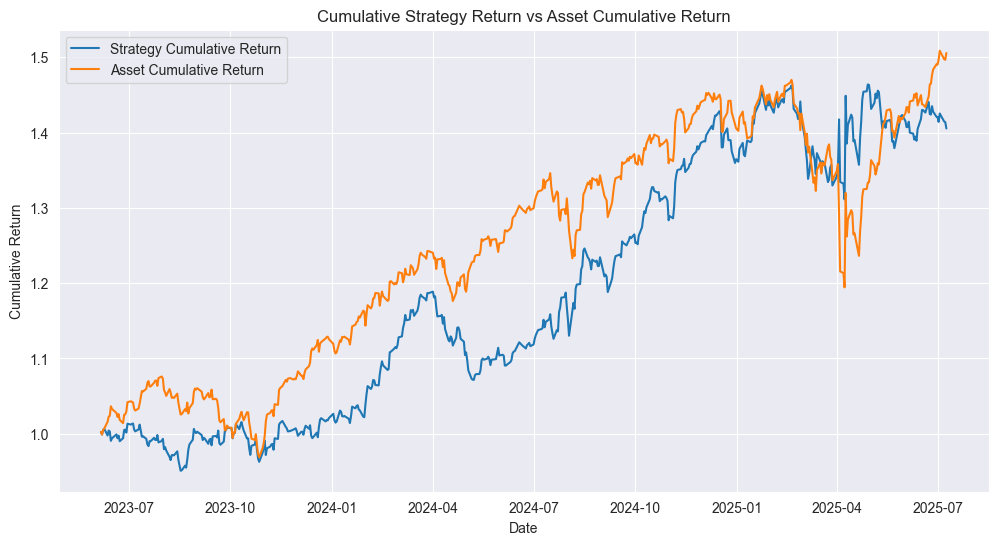

In [481]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(data_with_returns_spy_svm['Date'], data_with_returns_spy_svm['cumulative_strategy'], label='Strategy Cumulative Return')
plt.plot(data_with_returns_spy_svm['Date'], data_with_returns_spy_svm['cumulative_asset'], label='Asset Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Strategy Return vs Asset Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

Reuse of the trained rbf svm model based on SPY and implement it on TSLA

In [482]:
# Data Processing
data_tsla_svm = fetch_data('TSLA', '2015-01-01', '2025-07-12')
train_frac = 0.8
X_tsla_svm, Y_tsla_svm, X_tsla_svm_train, Y_tsla_svm_train, X_tsla_svm_test, Y_tsla_svm_test, data_tsla_svm = return_data_daily_return(data_tsla_svm, target_type='Target_Sign', train_frac=train_frac, features='whole')
X_tsla_svm = standardize(X_tsla_svm)
X_tsla_svm_train = standardize(X_tsla_svm_train)
X_tsla_svm_test = standardize(X_tsla_svm_test)

/var/folders/pz/bkvmpwns7mgcx9s_bqb2lbyc0000gn/T/ipykernel_3367/1753287488.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [483]:
# Model Transfer and Evaluation
y_pred_test_tsla_svm = rbf_svm(X_tsla_svm)
test_acc_tsla_svm = binary_accuracy(y_pred_test_tsla_svm, Y_tsla_svm)
print("Test Accuracy:", test_acc_tsla_svm)

Test Accuracy: 50.51428571428571


In [484]:
data_processed_tsla_svm = process_predictions(data_tsla_svm, rbf_svm(X_tsla_svm_test), train_frac, pred_col_name='rbf_svm_pred')

Number of -1 predictions: 148
Number of 1 predictions:  376


In [485]:
data_with_returns_tsla_svm = calculate_returns(data_processed_tsla_svm, pred_col='rbf_svm_pred', return_col='Daily_Return')

Strategy return is 300.96%
Asset return is 35.97%


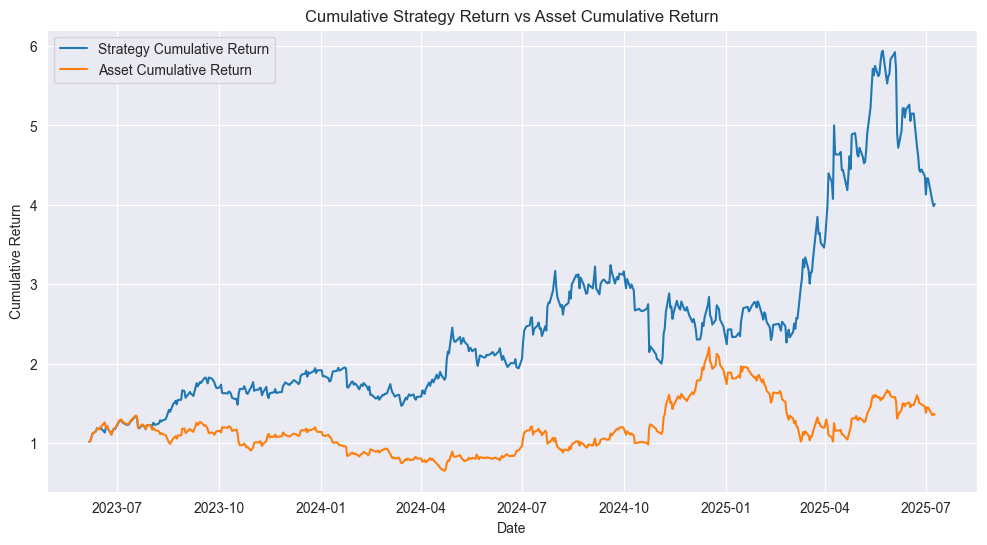

In [486]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(data_with_returns_tsla_svm['Date'], data_with_returns_tsla_svm['cumulative_strategy'], label='Strategy Cumulative Return')
plt.plot(data_with_returns_tsla_svm['Date'], data_with_returns_tsla_svm['cumulative_asset'], label='Asset Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Strategy Return vs Asset Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

## Logistic Regression

In [487]:
# Data Processing
data_spy_reg = fetch_data('SPY', '2015-01-01', '2025-07-12')
train_frac = 0.8
X_spy_reg, Y_spy_reg, X_spy_reg_train, Y_spy_reg_train, X_spy_reg_test, Y_spy_reg_test, data_spy_reg = return_data_daily_return(data_spy_reg, target_type='Target_Sign_01', train_frac=train_frac, features='whole')
X_spy_reg = standardize(X_spy_reg)
X_spy_reg_train = standardize(X_spy_reg_train)
X_spy_reg_test = standardize(X_spy_reg_test)

/var/folders/pz/bkvmpwns7mgcx9s_bqb2lbyc0000gn/T/ipykernel_3367/1753287488.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [568]:
# Model Training
w = [0]*X_spy_reg.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-4)
logistic_regression = LogisticRegression(w, b, optimizer)
metrics_history = logistic_regression.fit(X_spy_reg_train, Y_spy_reg_train, num_epochs=50000, batch_size=len(X_spy_reg_train))

In [569]:
#Test Accuracy
y_pred_test_spy_reg = logistic_regression(X_spy_reg_test)
test_acc = binary_accuracy(y_pred_test_spy_reg, Y_spy_reg_test, class_labels=[0, 1])
print("Test Accuracy:", test_acc)

Test Accuracy: 57.904761904761905


Trading Strategy with Logistic Regression

In [571]:
data_processed_spy_reg = process_predictions(data_spy_reg,y_pred_test_spy_reg,train_frac,pred_col_name = 'logistic_pred',logistic = True)


Number of -1 predictions: 17
Number of 1 predictions:  507


/var/folders/pz/bkvmpwns7mgcx9s_bqb2lbyc0000gn/T/ipykernel_3367/3656233791.py:65: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_copy[pred_col_name].replace(0, -1, inplace=True)


In [573]:
data_with_returns_spy_reg = calculate_returns(data_processed_spy_reg, pred_col='logistic_pred', return_col='Daily_Return')

Strategy return is 49.11%
Asset return is 50.56%


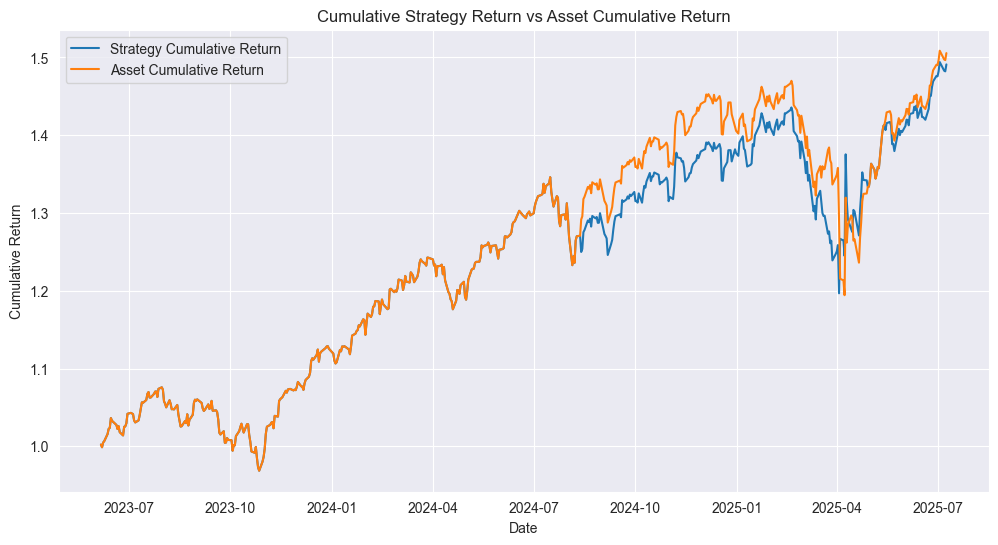

In [574]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(data_with_returns_spy_reg['Date'], data_with_returns_spy_reg['cumulative_strategy'], label='Strategy Cumulative Return')
plt.plot(data_with_returns_spy_reg['Date'], data_with_returns_spy_reg['cumulative_asset'], label='Asset Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Strategy Return vs Asset Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

Reuse of the trained Logistic model based on SPY and implement it on TSLA

In [452]:
# Data Processing
data_tsla_reg = fetch_data('TSLA', '2015-01-01', '2025-07-12')
train_frac = 0.8
X_tsla_reg, Y_tsla_reg, X_tsla_reg_train, Y_tsla_reg_train, X_tsla_reg_test, Y_tsla_reg_test, data_tsla_reg = return_data_daily_return(data_tsla_reg, target_type='Target_Sign', train_frac=train_frac, features='whole')
X_tsla_reg = standardize(X_tsla_reg)
X_tsla_reg_train = standardize(X_tsla_reg_train)
X_tsla_reg_test = standardize(X_tsla_reg_test)

/var/folders/pz/bkvmpwns7mgcx9s_bqb2lbyc0000gn/T/ipykernel_3367/1753287488.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [577]:
# Model Transfer and Evaluation
y_pred_tsla_reg = logistic_regression(X_tsla_reg)
test_acc = binary_accuracy(y_pred_tsla_reg, Y_tsla_reg, class_labels=[0, 1])
print("Test Accuracy:", test_acc)

Test Accuracy: 48.34285714285714


In [578]:
data_processed_tsla_reg = process_predictions(data_tsla_reg, logistic_regression(X_tsla_reg_test),train_frac,pred_col_name = 'logistic_pred',logistic = True)

Number of -1 predictions: 46
Number of 1 predictions:  478


/var/folders/pz/bkvmpwns7mgcx9s_bqb2lbyc0000gn/T/ipykernel_3367/3656233791.py:65: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_copy[pred_col_name].replace(0, -1, inplace=True)


In [579]:
data_with_returns_tsla_reg = calculate_returns(data_processed_tsla_reg, pred_col='logistic_pred', return_col='Daily_Return')

Strategy return is 132.01%
Asset return is 35.97%


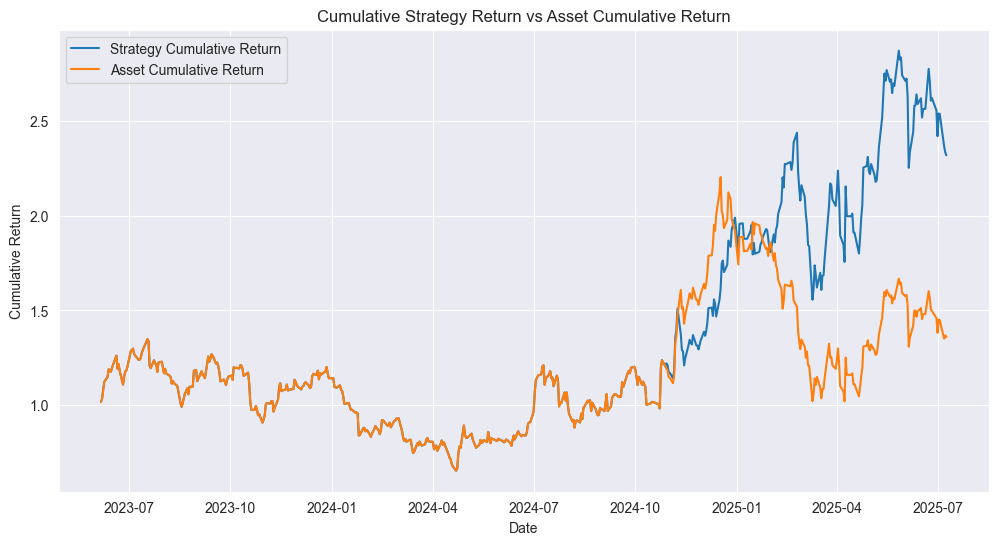

In [580]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(data_with_returns_tsla_reg['Date'], data_with_returns_tsla_reg['cumulative_strategy'], label='Strategy Cumulative Return')
plt.plot(data_with_returns_tsla_reg['Date'], data_with_returns_tsla_reg['cumulative_asset'], label='Asset Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Strategy Return vs Asset Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

## Logistic Regression with Regularization

In [610]:
# Model Training
w = [0]*X_spy_reg.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-3)
logistic_regression = LogisticRegressionRegularization(w, b, optimizer,1e-2,'ridge')
metrics_history_experiment = logistic_regression.fit(X_spy_reg_train, Y_spy_reg_train, num_epochs=20000, batch_size=len(X_spy_reg_train))

In [611]:
#Test Accuracy
y_pred_test_spy_reg_experiment = logistic_regression(X_spy_reg_test)
test_acc = binary_accuracy(y_pred_test_spy_reg, Y_spy_reg_test, class_labels=[0, 1])
print("Test Accuracy:", test_acc)

Test Accuracy: 58.47619047619048


In [612]:
data_processed_spy_reg_experiment = process_predictions(data_spy_reg,y_pred_test_spy_reg_experiment,train_frac,pred_col_name = 'logistic_pred',logistic = True)

Number of -1 predictions: 14
Number of 1 predictions:  510


/var/folders/pz/bkvmpwns7mgcx9s_bqb2lbyc0000gn/T/ipykernel_3367/3656233791.py:65: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_copy[pred_col_name].replace(0, -1, inplace=True)


In [613]:
data_with_returns_spy_reg = calculate_returns(data_processed_spy_reg_experiment, pred_col='logistic_pred', return_col='Daily_Return')

Strategy return is 48.85%
Asset return is 50.56%


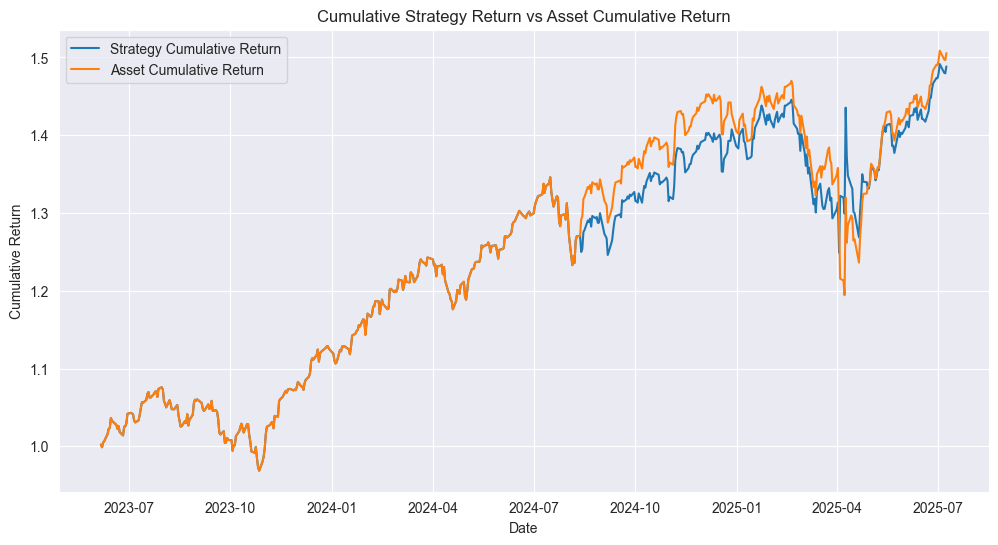

In [614]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(data_with_returns_spy_reg['Date'], data_with_returns_spy_reg['cumulative_strategy'], label='Strategy Cumulative Return')
plt.plot(data_with_returns_spy_reg['Date'], data_with_returns_spy_reg['cumulative_asset'], label='Asset Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Strategy Return vs Asset Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()